In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [4]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '36-resnet152'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_PATH = f'{COLAB_BASE_PATH}Submissions/{MODEL_NAME}.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [5]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [6]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [7]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.110.66.234:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Model parameters

In [8]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 256,
  "EPOCHS": 30,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "BASE_MODEL": 'resnet152',
  "BASE_MODEL_WEIGHTS": 'imagenet11k',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'resnet152',
 'BASE_MODEL_WEIGHTS': 'imagenet11k',
 'BATCH_SIZE': 256,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 30,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'WIDTH': 256}

# Load data

In [9]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-e12fcdd8602eaeb3e7343f4b322f78239cfa17e4bf5db65058b851ad' # KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')
GCS_PATH_EXT = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES_EXT = tf.io.gfile.glob(GCS_PATH_EXT + '/train*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [10]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [11]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000291 to 1.29e-05


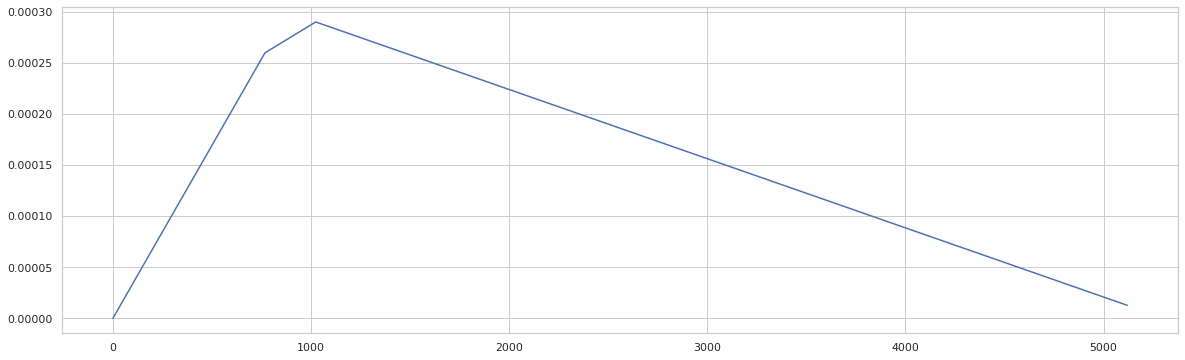

In [12]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get(config['BASE_MODEL'])
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_WEIGHTS'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [14]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

# Get original dataset validation indexes
val_idx_eval = []
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
  val_idx_eval.append(val_idx)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES_EXT)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES_EXT)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES_EXT)[val_idx]
        train_size = count_data_items(train_filenames)

        step_size = train_size // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=True, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)

            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=step_size,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        history_list.append(history)

        # Make predictions
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx_eval[n_fold-1]]
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


234332160/234326024 [==============================] - 3s 0us/step
Epoch 1/30
187/187 - 118s - loss: 0.3514 - auc: 0.7966 - val_loss: 0.3545 - val_auc: 0.5745
Epoch 2/30
187/187 - 79s - loss: 0.2707 - auc: 0.8889 - val_loss: 0.5595 - val_auc: 0.5074
Epoch 3/30
187/187 - 90s - loss: 0.2636 - auc: 0.9004 - val_loss: 0.3472 - val_auc: 0.5961
Epoch 4/30
187/187 - 78s - loss: 0.2569 - auc: 0.9081 - val_loss: 0.3783 - val_auc: 0.6323
Epoch 5/30
187/187 - 78s - loss: 0.2593 - auc: 0.9049 - val_loss: 0.3493 - val_auc: 0.8533
Epoch 6/30
187/187 - 90s - loss: 0.2551 - auc: 0.9141 - val_loss: 0.2827 - val_auc: 0.9036
Epoch 7/30
187/187 - 89s - loss: 0.2541 - auc: 0.9142 - val_loss: 0.2642 - val_auc: 0.9149
Epoch 8/30
187/187 - 78s - loss: 0.2510 - auc: 0.9189 - val_loss: 0.2908 - val_auc: 0.8954
Epoch 9/30
187/187 - 90s - loss: 0.2463 - auc: 0.9222 - val_loss: 0.2410 - val_auc: 0.9285
Epoch 10/30
187/187 - 78s - loss: 0.2434 - auc: 0.9278 - val_loss: 0.5578 - val_auc: 0.9094
Epoch 11/30
187/187 -

INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
187/187 - 111s - loss: 0.3079 - auc: 0.8260 - val_loss: 0.3620 - val_auc: 0.5301
Epoch 2/30
187/187 - 90s - loss: 0.2683 - auc: 0.8863 - val_loss: 0.3554 - val_auc: 0.4674
Epoch 3/30
187/187 - 79s - loss: 0.2656 - auc: 0.8948 - val_loss: 0.4391 - val_auc: 0.4869
Epoch 4/30
187/187 - 79s - loss: 0.2585 - auc: 0.9062 - val_loss: 0.5569 - val_auc: 0.4936
Epoch 5/30
187/187 - 79s - loss: 0.2596 - auc: 0.9032 - val_loss: 0.4437 - val_auc: 0.7859
Epoch 6/30
187/187 - 90s - loss: 0.2544 - auc: 0.9110 - val_loss: 0.3045 - val_auc: 0.8371
Epoch 7/30
187/187 - 90s - loss: 0.2539 - auc: 0.9125 - val_loss: 0.2875 - val_auc: 0.9127
Epoch 8/30
187/187 - 79s - loss: 0.2477 - auc: 0.9210 - val_loss: 0.3191 - val_auc: 0.9252
Epoch 9/30
187/187 - 79s - loss: 0.2467 - auc: 0.9181 - val_loss: 0.2939 - val_auc: 0.9125
Epoch 10/30
187/187 - 79s - loss: 0.2445 - auc: 0.9245 - val_loss: 0.3046 - val_auc: 0.8854
Epoch 11/30
187/187 - 92s - loss: 0.2402 - auc: 0.9296 - val_loss: 0.2576 - val_auc: 0.9

INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
194/194 - 117s - loss: 0.3205 - auc: 0.8174 - val_loss: 0.3566 - val_auc: 0.4558
Epoch 2/30
194/194 - 81s - loss: 0.2635 - auc: 0.8964 - val_loss: 0.4445 - val_auc: 0.5264
Epoch 3/30
194/194 - 81s - loss: 0.2583 - auc: 0.9042 - val_loss: 0.4014 - val_auc: 0.6068
Epoch 4/30
194/194 - 81s - loss: 0.2562 - auc: 0.9071 - val_loss: 0.3577 - val_auc: 0.5153
Epoch 5/30
194/194 - 81s - loss: 0.2561 - auc: 0.9096 - val_loss: 0.4128 - val_auc: 0.7893
Epoch 6/30
194/194 - 92s - loss: 0.2521 - auc: 0.9150 - val_loss: 0.2885 - val_auc: 0.8990
Epoch 7/30
194/194 - 81s - loss: 0.2498 - auc: 0.9183 - val_loss: 0.3074 - val_auc: 0.8918
Epoch 8/30
194/194 - 81s - loss: 0.2475 - auc: 0.9189 - val_loss: 0.3165 - val_auc: 0.9000
Epoch 9/30
194/194 - 92s - loss: 0.2428 - auc: 0.9268 - val_loss: 0.2568 - val_auc: 0.9194
Epoch 10/30
194/194 - 81s - loss: 0.2388 - auc: 0.9314 - val_loss: 0.2703 - val_auc: 0.9070
Epoch 11/30
194/194 - 81s - loss: 0.2385 - auc: 0.9305 - val_loss: 0.2573 - val_auc: 0.9

INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
187/187 - 110s - loss: 0.3190 - auc: 0.8212 - val_loss: 0.4166 - val_auc: 0.5673
Epoch 2/30
187/187 - 91s - loss: 0.2682 - auc: 0.8913 - val_loss: 0.3580 - val_auc: 0.3974
Epoch 3/30
187/187 - 79s - loss: 0.2584 - auc: 0.9072 - val_loss: 0.3847 - val_auc: 0.4844
Epoch 4/30
187/187 - 79s - loss: 0.2595 - auc: 0.9077 - val_loss: 0.3828 - val_auc: 0.5288
Epoch 5/30
187/187 - 90s - loss: 0.2570 - auc: 0.9115 - val_loss: 0.3201 - val_auc: 0.7808
Epoch 6/30
187/187 - 90s - loss: 0.2550 - auc: 0.9106 - val_loss: 0.2707 - val_auc: 0.8983
Epoch 7/30
187/187 - 80s - loss: 0.2508 - auc: 0.9191 - val_loss: 0.4068 - val_auc: 0.8719
Epoch 8/30
187/187 - 79s - loss: 0.2492 - auc: 0.9205 - val_loss: 0.3102 - val_auc: 0.9034
Epoch 9/30
187/187 - 79s - loss: 0.2462 - auc: 0.9239 - val_loss: 0.2851 - val_auc: 0.9118
Epoch 10/30
187/187 - 90s - loss: 0.2435 - auc: 0.9262 - val_loss: 0.2584 - val_auc: 0.9134
Epoch 11/30
187/187 - 79s - loss: 0.2410 - auc: 0.9287 - val_loss: 0.2616 - val_auc: 0.9

INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
187/187 - 112s - loss: 0.3969 - auc: 0.7827 - val_loss: 0.3527 - val_auc: 0.5060
Epoch 2/30
187/187 - 79s - loss: 0.2642 - auc: 0.8987 - val_loss: 0.3782 - val_auc: 0.3973
Epoch 3/30
187/187 - 84s - loss: 0.2597 - auc: 0.9061 - val_loss: 0.3736 - val_auc: 0.5808
Epoch 4/30
187/187 - 80s - loss: 0.2573 - auc: 0.9103 - val_loss: 0.3837 - val_auc: 0.7740
Epoch 5/30
187/187 - 91s - loss: 0.2571 - auc: 0.9107 - val_loss: 0.3330 - val_auc: 0.8261
Epoch 6/30
187/187 - 91s - loss: 0.2545 - auc: 0.9139 - val_loss: 0.2674 - val_auc: 0.8912
Epoch 7/30
187/187 - 91s - loss: 0.2509 - auc: 0.9182 - val_loss: 0.2589 - val_auc: 0.9131
Epoch 8/30
187/187 - 91s - loss: 0.2478 - auc: 0.9221 - val_loss: 0.2581 - val_auc: 0.9060
Epoch 9/30
187/187 - 90s - loss: 0.2443 - auc: 0.9276 - val_loss: 0.2477 - val_auc: 0.9229
Epoch 10/30
187/187 - 80s - loss: 0.2424 - auc: 0.9277 - val_loss: 0.2985 - val_auc: 0.9124
Epoch 11/30
187/187 - 91s - loss: 0.2386 - auc: 0.9334 - val_loss: 0.2460 - val_auc: 0.9

## Model loss graph

Fold: 1


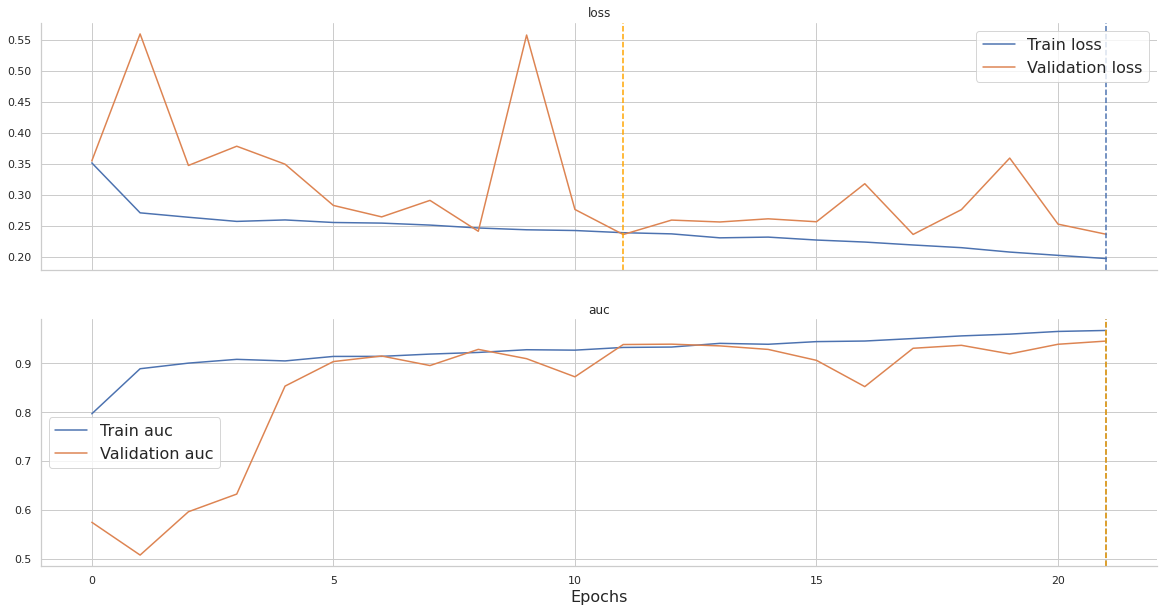

Fold: 2


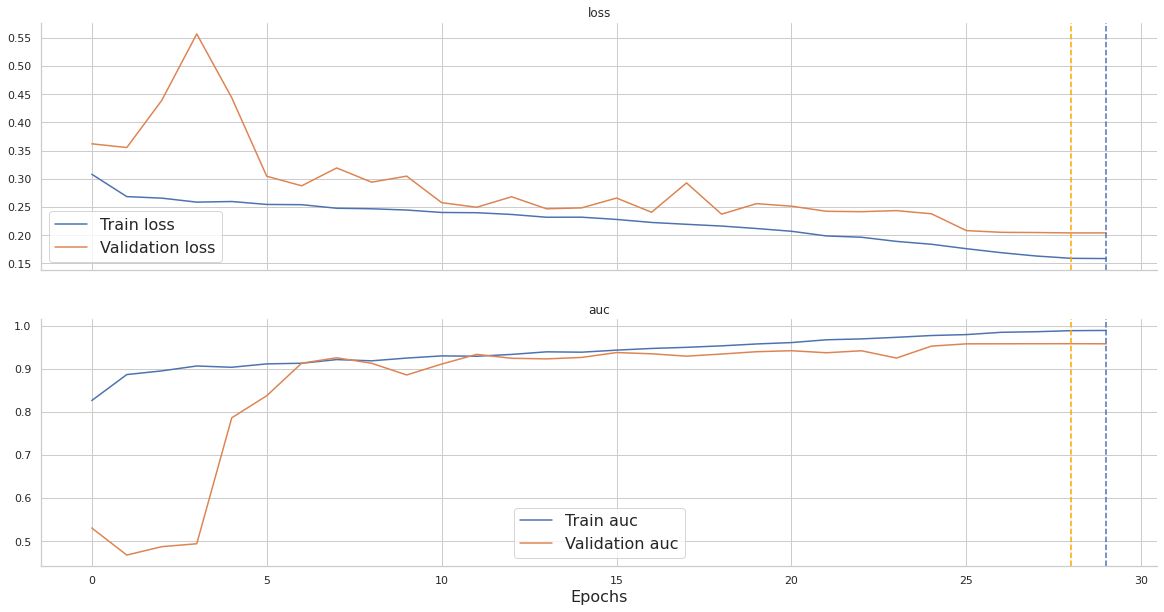

Fold: 3


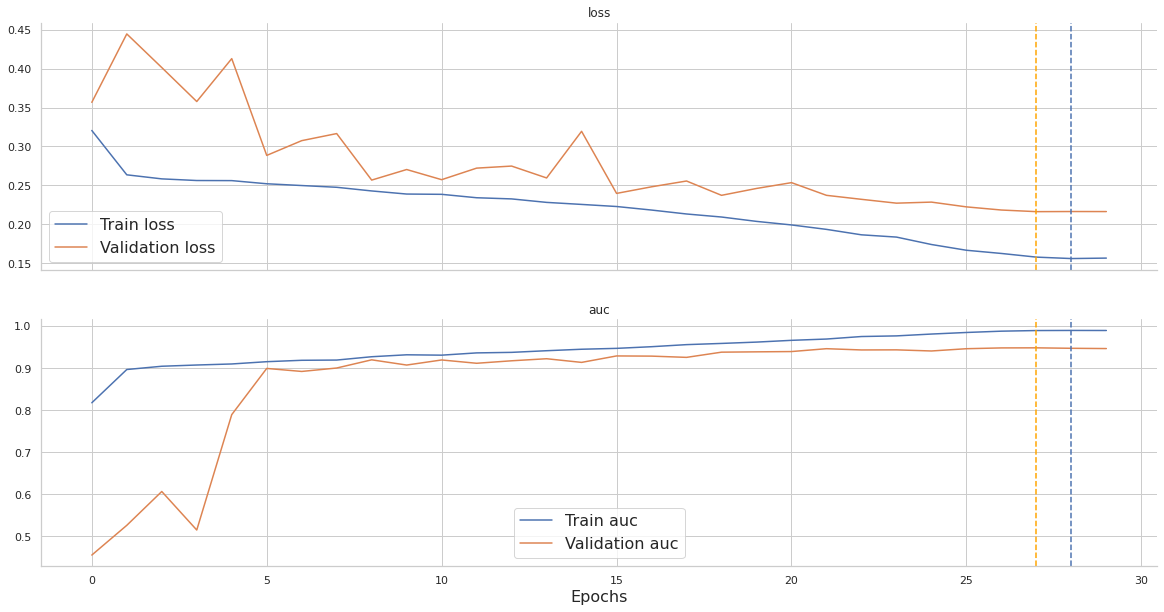

Fold: 4


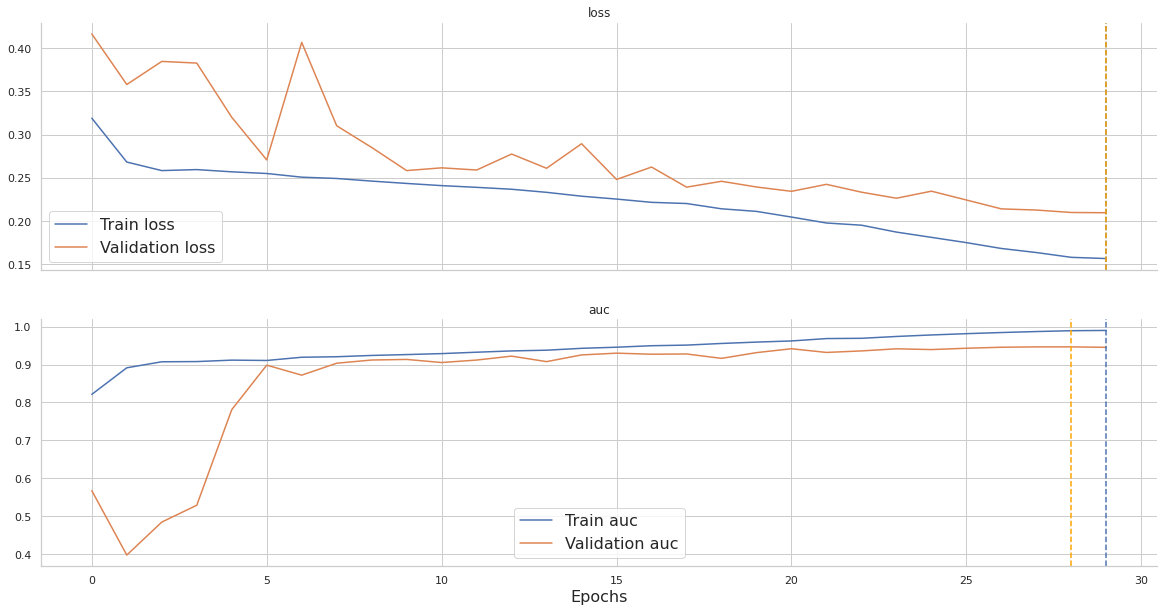

Fold: 5


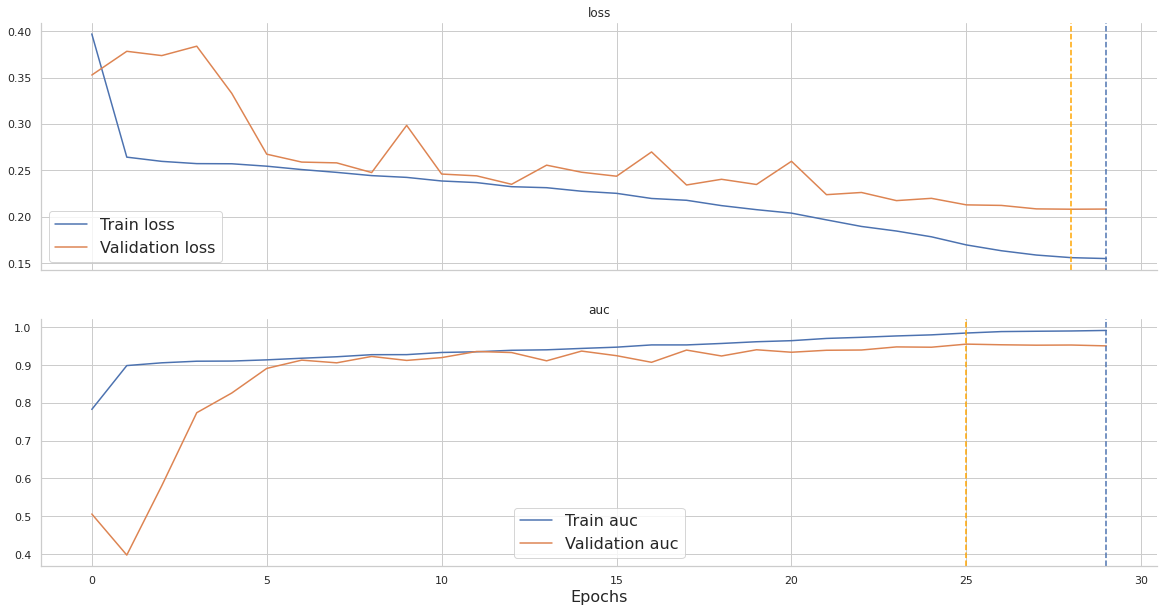

In [15]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

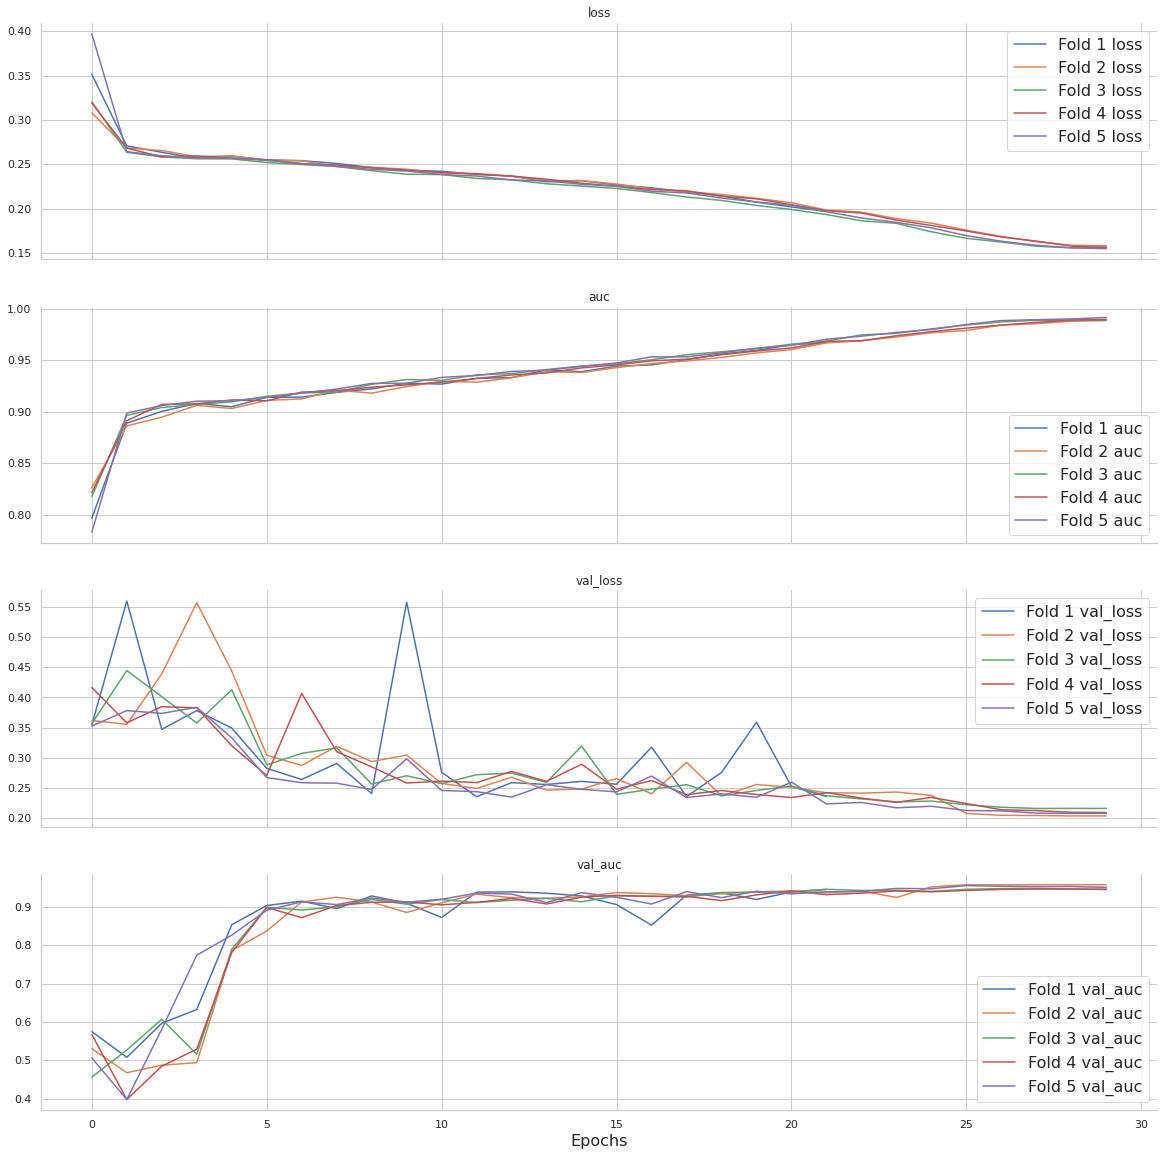

In [16]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [17]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.935322,0.940607,-0.005285,0.910512,0.910823,0.940049,0.956367,0.939706,0.945323,0.940209,0.921374,0.946135,0.969148
Accuracy,0.987559,0.987514,0.000045,0.982530,0.982496,0.988296,0.988733,0.988779,0.989216,0.988560,0.987587,0.989633,0.989538
Precision,0.747760,0.723883,0.023877,0.526012,0.450000,0.778947,0.777778,0.847737,0.810811,0.786713,0.769231,0.799392,0.811594
Recall,0.428071,0.426534,0.001537,0.205418,0.127660,0.468354,0.509091,0.437367,0.530973,0.476695,0.446429,0.552521,0.518519
F1-score,0.540910,0.530746,0.010164,0.295455,0.198895,0.584980,0.615385,0.577031,0.641711,0.593668,0.564972,0.653416,0.632768
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [18]:
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.935322,0.940607,-0.005285,0.910512,0.910823,0.940049,0.956367,0.939706,0.945323,0.940209,0.921374,0.946135,0.969148
male,0.941173,0.944911,-0.003738,0.910721,0.921679,0.945344,0.945008,0.946235,0.945154,0.947775,0.926327,0.955793,0.986390
female,0.924173,0.937162,-0.012988,0.905579,0.895810,0.931795,0.983462,0.928917,0.945542,0.925729,0.913879,0.928847,0.947116
head/neck,0.936808,0.943963,-0.007154,0.902020,0.923721,0.932496,0.912212,0.946363,0.931889,0.933722,0.971555,0.969440,0.980437
upper extremity,0.935369,0.956251,-0.020882,0.917661,0.931580,0.938274,0.979425,0.932183,0.975962,0.956706,0.949682,0.932019,0.944605
lower extremity,0.913446,0.901930,0.011515,0.895671,0.860937,0.931764,0.933342,0.907453,0.916806,0.904021,0.804534,0.928320,0.994032
torso,0.942526,0.952298,-0.009772,0.913573,0.917097,0.943540,0.971163,0.955851,0.954594,0.948030,0.939247,0.951634,0.979388
0 <= age < 26,0.882738,0.947204,-0.064466,0.891046,0.966783,0.882137,0.854988,0.916475,0.965827,0.912206,0.980786,0.811827,0.967634
26 <= age < 40,0.935660,0.901626,0.034034,0.868573,0.851372,0.943344,0.969819,0.982550,0.832787,0.950756,0.869582,0.933075,0.984568


# Confusion matrix

Fold: 1


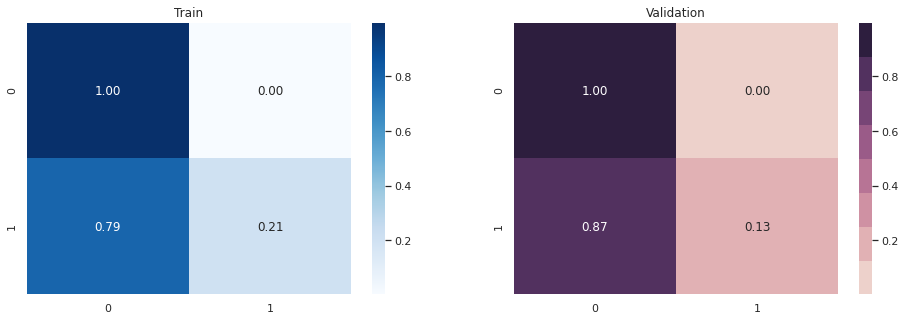

Fold: 2


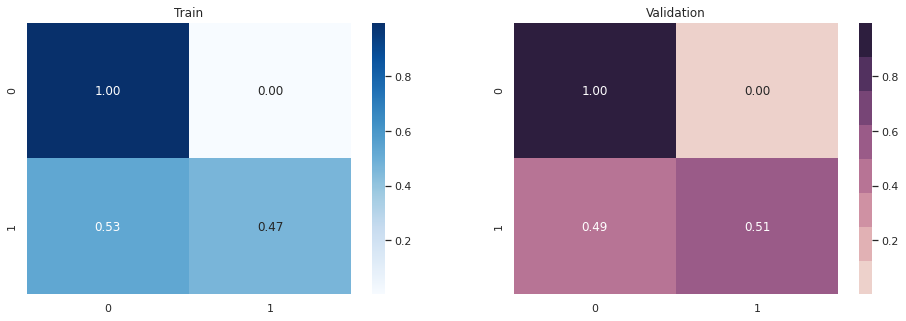

Fold: 3


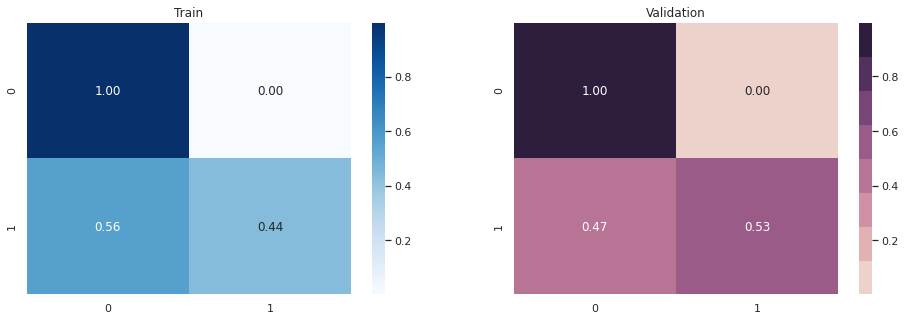

Fold: 4


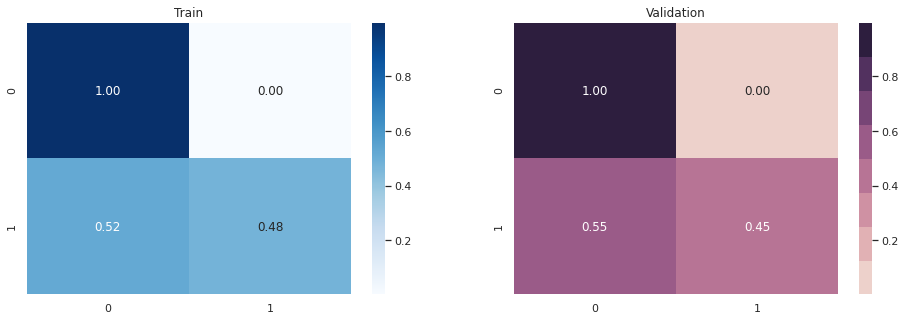

Fold: 5


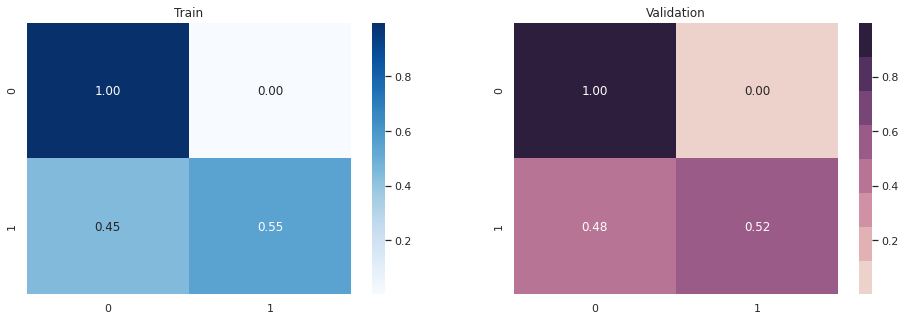

In [19]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [20]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.035832,0.064998,0.032397,0.029684,0.024647,0.027437
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.022720,0.023327,0.024061,0.019875,0.022239,0.024100
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.025621,0.028463,0.024985,0.023318,0.028259,0.023081
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.031189,0.047896,0.029713,0.036250,0.022424,0.019661
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.021039,0.018918,0.021422,0.021712,0.019101,0.024043
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.024150,0.017675,0.028473,0.021042,0.026853,0.026707
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.023532,0.025585,0.024249,0.020790,0.022261,0.024775
7,ISIC_0075663,female,35.0,torso,unknown,0,0.026715,0.045070,0.024278,0.014887,0.020889,0.028451
8,ISIC_0075914,male,30.0,torso,unknown,0,0.023436,0.016262,0.029651,0.023204,0.022296,0.025768
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.027832,0.022258,0.029165,0.029305,0.026187,0.032245


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.147871,0.040273,0.370433,0.030624,0.268178,0.029845
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.543514,0.064571,0.102117,0.785270,0.827436,0.938175
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.264841,0.204753,0.022182,0.208247,0.111527,0.777495
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.282344,0.257752,0.491227,0.208976,0.408258,0.045505
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.618641,0.200630,0.814290,0.920979,0.202352,0.954953
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.901295,0.557714,0.989134,0.990764,0.993760,0.975101
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.057594,0.056395,0.117772,0.051758,0.032375,0.029668
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.314396,0.044066,0.751518,0.513365,0.167277,0.095753
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.214098,0.105655,0.202228,0.121080,0.418498,0.223026
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.087657,0.051720,0.033821,0.031245,0.259296,0.062206


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.543514,0.064571,0.102117,0.785270,0.827436,0.938175
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.618641,0.200630,0.814290,0.920979,0.202352,0.954953
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.901295,0.557714,0.989134,0.990764,0.993760,0.975101
707,ISIC_0314462,male,80.0,torso,unknown,0,0.572455,0.769822,0.218282,0.301260,0.821957,0.750954
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.975520,0.972118,0.988644,0.958074,0.981294,0.977470
826,ISIC_0351666,male,80.0,head/neck,melanoma,1,0.626855,0.468141,0.233074,0.855544,0.812186,0.765331
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.785440,0.230843,0.898834,0.875035,0.955489,0.966997
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.962743,0.919479,0.994767,0.935714,0.979413,0.984342
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.939267,0.900455,0.993878,0.960319,0.945183,0.896500
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.814819,0.126427,0.994722,0.987352,0.984677,0.980919


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 280
Train positive correct predictions: 256


# Make predictions

In [21]:
model_path_list = glob.glob(MODEL_BASE_PATH + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_3.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_4.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_5.h5


In [22]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_1.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_2.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_3.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_4.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/36-resnet152/model_fold_5.h5


# Visualize test predictions

In [23]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 92|10890
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.024642
1,ISIC_0052349,male,40.0,lower extremity,0.022836
2,ISIC_0058510,female,55.0,torso,0.022309
3,ISIC_0073313,female,50.0,torso,0.022781
4,ISIC_0073502,female,45.0,lower extremity,0.031165
5,ISIC_0074618,male,50.0,lower extremity,0.031615
6,ISIC_0076801,male,45.0,upper extremity,0.022441
7,ISIC_0077586,male,50.0,lower extremity,0.029749
8,ISIC_0082004,female,45.0,torso,0.029434
9,ISIC_0082785,male,65.0,lower extremity,0.024647


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
24,ISIC_0112420,female,65.0,torso,0.878541
296,ISIC_0391046,male,85.0,torso,0.846765
403,ISIC_0481105,male,80.0,torso,0.873674
471,ISIC_0539432,female,45.0,lower extremity,0.869527
530,ISIC_0588352,male,60.0,lower extremity,0.570347
552,ISIC_0606244,male,70.0,torso,0.591146
596,ISIC_0637104,female,80.0,torso,0.619891
764,ISIC_0775584,female,35.0,lower extremity,0.668091
1250,ISIC_1212424,male,55.0,torso,0.659535
1286,ISIC_1247763,male,50.0,torso,0.534543


# Test set predictions

In [24]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv(SUBMISSION_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.024642
1,ISIC_0052349,0.022836
2,ISIC_0058510,0.022309
3,ISIC_0073313,0.022781
4,ISIC_0073502,0.031165
5,ISIC_0074618,0.031615
6,ISIC_0076801,0.022441
7,ISIC_0077586,0.029749
8,ISIC_0082004,0.029434
9,ISIC_0082785,0.024647


,target
count,10982.000000
mean,0.044045
std,0.077266
min,0.014787
25%,0.023387
50%,0.026368
75%,0.033486
max,0.985071
